# Description

TODO

# Modules

In [1]:
import re

import pandas as pd
import numpy as np

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.preprocessing import minmax_scale

from clustermatch import conf
from clustermatch.coef import cm

# Settings

In [2]:
# DATASET_CONFIG = conf.GTEX
# GTEX_TISSUE = "whole_blood"
# GENE_SEL_STRATEGY = "var_pc_log2"

# Paths

In [3]:
TISSUE_DIR = conf.GTEX["DATA_DIR"] / "data_by_tissue"
assert TISSUE_DIR.exists()

# Data

## GTEx samples info

In [4]:
gtex_samples = pd.read_csv(
    conf.GTEX["DATA_DIR"] / "GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt",
    sep="\t",
    index_col="SAMPID",
)

In [5]:
display(gtex_samples.shape)
assert gtex_samples.index.is_unique

(22951, 62)

In [6]:
gtex_samples.head()

,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-6WBT7,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10a-SM-AHZ7F,NaN,"B1, A1",NaN,NaN,Brain,Brain - Frontal Cortex (BA9),0009834,1193.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10b-SM-CYKQ8,NaN,"B1, A1",NaN,7.2,Brain,Brain - Frontal Cortex (BA9),0009834,1193.0,NaN,BP-42319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## GTEx subject phenotypes

In [7]:
gtex_phenotypes = pd.read_csv(
    conf.GTEX["DATA_DIR"] / "GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt",
    sep="\t",
)

In [8]:
gtex_phenotypes.shape

(980, 4)

In [9]:
gtex_phenotypes.head()

,SUBJID,SEX,AGE,DTHHRDY
0,GTEX-1117F,2,60-69,4.0
1,GTEX-111CU,1,50-59,0.0
2,GTEX-111FC,1,60-69,1.0
3,GTEX-111VG,1,60-69,3.0
4,GTEX-111YS,1,60-69,0.0


## GTEx gene expression sample

In [10]:
pd.read_pickle(next(TISSUE_DIR.glob("*.pkl"))).head()

,GTEX-111FC-0826-SM-5GZWO,GTEX-111YS-0426-SM-5987O,GTEX-1122O-0826-SM-5GICV,GTEX-117YW-0326-SM-5N9CY,GTEX-117YX-1126-SM-5H128,GTEX-11DXX-0326-SM-5PNWC,GTEX-11DXY-0826-SM-5EGGR,GTEX-11DXZ-0626-SM-5GU77,GTEX-11EM3-0626-SM-5H12Z,GTEX-11EMC-0726-SM-5EGJO,...,GTEX-ZTPG-1226-SM-4YCDO,GTEX-ZUA1-0826-SM-4YCDL,GTEX-ZV7C-0326-SM-57WB1,GTEX-ZVT2-1026-SM-5GU55,GTEX-ZVZP-0226-SM-5NQ73,GTEX-ZYFC-1126-SM-5E44W,GTEX-ZYFG-0426-SM-5E43M,GTEX-ZYT6-1726-SM-5E44P,GTEX-ZYW4-0926-SM-59HJS,GTEX-ZZPU-0926-SM-5GZYT
gene_ens_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,0.00000,0.00000,0.01863,0.0132,0.0000,0.01595,0.00000,0.02215,0.0000,0.000,...,0.03078,0.0000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.01152,0.0000
ENSG00000227232.5,2.45800,0.71900,0.77600,1.2890,0.3104,0.41540,0.47550,2.68200,0.6632,1.421,...,1.00200,0.5498,0.97870,0.69250,0.69030,1.86900,0.3865,0.67120,0.64470,1.0160
ENSG00000278267.1,0.00000,0.00000,0.00000,0.0000,0.0000,0.40560,0.00000,0.00000,0.0000,0.000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.4723
ENSG00000243485.5,0.03116,0.03063,0.00000,0.0527,0.0000,0.03185,0.02352,0.08846,0.0000,0.000,...,0.06145,0.0000,0.03193,0.06436,0.03308,0.00000,0.0000,0.05938,0.06897,0.0000
ENSG00000237613.2,0.00000,0.02176,0.00000,0.0000,0.0000,0.02263,0.00000,0.00000,0.0000,0.000,...,0.04366,0.0000,0.02269,0.00000,0.00000,0.03842,0.0000,0.01406,0.00000,0.0000


## Gene Ensembl ID -> Symbol mapping

In [11]:
gene_map = pd.read_pickle(conf.GTEX["DATA_DIR"] / "gtex_gene_id_symbol_mappings.pkl")

In [12]:
gene_map = gene_map.set_index("gene_ens_id")["gene_symbol"].to_dict()

In [13]:
assert gene_map["ENSG00000145309.5"] == "CABS1"

# Run

In [14]:
# there are the two sex chromosome genes:
# ('ENSG00000147050.14', 'ENSG00000183878.15')
# ('KDM6A', 'UTY')
gene0_id, gene1_id = "ENSG00000147050.14", "ENSG00000183878.15"

In [15]:
res_all = pd.DataFrame(
    {
        f.stem.split("_data_")[1]: {
            "cm": cm(data[gene0_id], data[gene1_id]),
            "pearson": pearsonr(data[gene0_id], data[gene1_id])[0],
            "spearman": spearmanr(data[gene0_id], data[gene1_id])[0],
        }
        for f in TISSUE_DIR.glob("*.pkl")
        if (data := pd.read_pickle(f).T[[gene0_id, gene1_id]].dropna()) is not None
        and data.shape[0] > 10
    }
).T.abs()

In [16]:
res_all.shape

(50, 3)

In [17]:
res_all.head()

,cm,pearson,spearman
heart_left_ventricle,0.334440,0.183529,0.006030
heart_atrial_appendage,0.246321,0.095973,0.039109
vagina,0.013525,0.074307,0.086761
adipose_visceral_omentum,0.280211,0.198846,0.053794
brain_nucleus_accumbens_basal_ganglia,0.291776,0.249914,0.256930


In [18]:
res_all.sort_values("cm")

,cm,pearson,spearman
uterus,0.000000,0.016338,0.041994
ovary,0.006722,0.104096,0.013011
vagina,0.013525,0.074307,0.086761
brain_cerebellum,0.187717,0.124874,0.036402
small_intestine_terminal_ileum,0.193668,0.359150,0.327394
brain_spinal_cord_cervical_c1,0.198741,0.243850,0.125183
testis,0.206704,0.692661,0.690990
stomach,0.209703,0.437367,0.346836
brain_cortex,0.219900,0.162729,0.144386
brain_anterior_cingulate_cortex_ba24,0.231620,0.002993,0.182207


In [19]:
res_all.sort_values("pearson")

,cm,pearson,spearman
brain_anterior_cingulate_cortex_ba24,0.231620,0.002993,0.182207
uterus,0.000000,0.016338,0.041994
brain_amygdala,0.280524,0.037541,0.147571
brain_frontal_cortex_ba9,0.265633,0.051099,0.188904
bladder,0.330097,0.061798,0.022107
vagina,0.013525,0.074307,0.086761
heart_atrial_appendage,0.246321,0.095973,0.039109
ovary,0.006722,0.104096,0.013011
brain_caudate_basal_ganglia,0.287850,0.118342,0.199696
brain_cerebellum,0.187717,0.124874,0.036402


In [20]:
res_all.sort_values("spearman")

,cm,pearson,spearman
heart_left_ventricle,0.334440,0.183529,0.006030
ovary,0.006722,0.104096,0.013011
bladder,0.330097,0.061798,0.022107
brain_cerebellum,0.187717,0.124874,0.036402
heart_atrial_appendage,0.246321,0.095973,0.039109
uterus,0.000000,0.016338,0.041994
adipose_visceral_omentum,0.280211,0.198846,0.053794
vagina,0.013525,0.074307,0.086761
whole_blood,0.294391,0.239870,0.100621
brain_spinal_cord_cervical_c1,0.198741,0.243850,0.125183


# Get GTEx sample metadata

In [21]:
gtex_samples_list = gtex_samples.index.to_list()
display(gtex_samples_list[:5])

['GTEX-1117F-0003-SM-58Q7G',
 'GTEX-1117F-0003-SM-5DWSB',
 'GTEX-1117F-0003-SM-6WBT7',
 'GTEX-1117F-0011-R10a-SM-AHZ7F',
 'GTEX-1117F-0011-R10b-SM-CYKQ8']

In [22]:
_tmp_cols_df = pd.Series(gtex_samples_list).rename("SAMPID")

In [23]:
_tmp_cols_df

0             GTEX-1117F-0003-SM-58Q7G
1             GTEX-1117F-0003-SM-5DWSB
2             GTEX-1117F-0003-SM-6WBT7
3        GTEX-1117F-0011-R10a-SM-AHZ7F
4        GTEX-1117F-0011-R10b-SM-CYKQ8
                     ...              
22946                   K-562-SM-E9EZC
22947                   K-562-SM-E9EZI
22948                   K-562-SM-E9EZO
22949                   K-562-SM-E9EZT
22950                   K-562-SM-E9EZZ
Name: SAMPID, Length: 22951, dtype: object

In [24]:
_tmp_cols_subjects = _tmp_cols_df.str.extract(
    r"([\w\d]+\-[\w\d]+)", flags=re.IGNORECASE, expand=True
)[0].rename("SUBJID")

In [25]:
_tmp_cols_subjects

0        GTEX-1117F
1        GTEX-1117F
2        GTEX-1117F
3        GTEX-1117F
4        GTEX-1117F
            ...    
22946         K-562
22947         K-562
22948         K-562
22949         K-562
22950         K-562
Name: SUBJID, Length: 22951, dtype: object

In [26]:
_tmp_cols_df = pd.concat([_tmp_cols_df, _tmp_cols_subjects], axis=1)

In [27]:
_tmp_cols_df

,SAMPID,SUBJID
0,GTEX-1117F-0003-SM-58Q7G,GTEX-1117F
1,GTEX-1117F-0003-SM-5DWSB,GTEX-1117F
2,GTEX-1117F-0003-SM-6WBT7,GTEX-1117F
3,GTEX-1117F-0011-R10a-SM-AHZ7F,GTEX-1117F
4,GTEX-1117F-0011-R10b-SM-CYKQ8,GTEX-1117F
...,...,...
22946,K-562-SM-E9EZC,K-562
22947,K-562-SM-E9EZI,K-562
22948,K-562-SM-E9EZO,K-562
22949,K-562-SM-E9EZT,K-562


In [28]:
gtex_phenotypes

,SUBJID,SEX,AGE,DTHHRDY
0,GTEX-1117F,2,60-69,4.0
1,GTEX-111CU,1,50-59,0.0
2,GTEX-111FC,1,60-69,1.0
3,GTEX-111VG,1,60-69,3.0
4,GTEX-111YS,1,60-69,0.0
...,...,...,...,...
975,GTEX-ZYY3,2,60-69,4.0
976,GTEX-ZZ64,1,20-29,0.0
977,GTEX-ZZPT,1,50-59,4.0
978,GTEX-ZZPU,2,50-59,0.0


In [29]:
_tmp_cols_df = pd.merge(_tmp_cols_df, gtex_phenotypes).set_index("SAMPID")

In [30]:
_tmp_cols_df = _tmp_cols_df.replace(
    {
        "SEX": {
            1: "Male",
            2: "Female",
        }
    }
)

In [31]:
_tmp_cols_df

,SUBJID,SEX,AGE,DTHHRDY
SAMPID,,,,
GTEX-1117F-0003-SM-58Q7G,GTEX-1117F,Female,60-69,4.0
GTEX-1117F-0003-SM-5DWSB,GTEX-1117F,Female,60-69,4.0
GTEX-1117F-0003-SM-6WBT7,GTEX-1117F,Female,60-69,4.0
GTEX-1117F-0011-R10a-SM-AHZ7F,GTEX-1117F,Female,60-69,4.0
GTEX-1117F-0011-R10b-SM-CYKQ8,GTEX-1117F,Female,60-69,4.0
...,...,...,...,...
K-562-SM-E9EZC,K-562,Female,50-59,NaN
K-562-SM-E9EZI,K-562,Female,50-59,NaN
K-562-SM-E9EZO,K-562,Female,50-59,NaN


# Plot

In [32]:
def plot_gene_pair(
    tissue_name, gene0, gene1, hue=None, kind="hex", ylim=None, bins="log"
):
    # gene0, gene1 = top_pairs_df.iloc[idx].name
    # display((gene0, gene1))

    tissue_file = get_tissue_file(tissue_name)
    tissue_data = pd.read_pickle(tissue_file).T[[gene0, gene1]]
    n_samples = tissue_data.shape[0]
    tissue_data = pd.merge(
        tissue_data,
        _tmp_cols_df,
        how="inner",
        left_index=True,
        right_index=True,
        validate="one_to_one",
    )
    # tissue_data = pd.concat([tissue_data, _tmp_cols_df], axis=1, verify_integrity=True)
    # if n_samples 1= tissue_data.shape[0]:
    #     print("WARNING: merging failed: {}

    gene0_symbol, gene1_symbol = gene_map[gene0], gene_map[gene1]
    display((gene0_symbol, gene1_symbol))

    # _pearson, _spearman, _clustermatch = top_pairs_df.loc[
    #     (gene0, gene1), ["pearson", "spearman", "clustermatch"]
    # ].tolist()

    # _title = f"Clustermatch: {_clustermatch:.2f}\nPearson/Spearman: {_pearson:.2f}/{_spearman:.2f}"

    other_args = {
        "kind": kind,  # if hue is None else "scatter",
    }
    if hue is None:
        other_args["bins"] = bins

    p = sns.jointplot(
        data=tissue_data,
        x=gene0,
        y=gene1,
        hue=hue,
        **other_args,
        # ylim=(0, 500),
    )

    if ylim is not None:
        p.ax_joint.set_ylim(ylim)

    gene_x_id = p.ax_joint.get_xlabel()
    gene_x_symbol = gene_map[gene_x_id]
    p.ax_joint.set_xlabel(f"{gene_x_id}\n{gene_x_symbol}")

    gene_y_id = p.ax_joint.get_ylabel()
    gene_y_symbol = gene_map[gene_y_id]
    p.ax_joint.set_ylabel(f"{gene_y_id}\n{gene_y_symbol}")

    # p.fig.suptitle(_title)

    return tissue_data

In [33]:
def get_tissue_file(name):
    for f in TISSUE_DIR.glob("*.pkl"):
        if name in f.name:
            return f

In [34]:
get_tissue_file("whole_blood")

PosixPath('/opt/data/data/gtex_v8/data_by_tissue/gtex_v8_data_whole_blood.pkl')

## In whole blood (where this gene pair was found)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-111YS-0006-SM-5NQBE,6.379,3.493000,GTEX-111YS,Male,60-69,0.0
GTEX-1122O-0005-SM-5O99J,23.650,0.000000,GTEX-1122O,Female,60-69,0.0
GTEX-1128S-0005-SM-5P9HI,14.920,0.007639,GTEX-1128S,Female,60-69,2.0
GTEX-113IC-0006-SM-5NQ9C,14.250,8.657000,GTEX-113IC,Male,60-69,NaN
GTEX-113JC-0006-SM-5O997,7.683,0.000000,GTEX-113JC,Female,50-59,2.0
...,...,...,...,...,...,...
GTEX-ZVTK-0006-SM-57WBK,8.614,5.286000,GTEX-ZVTK,Male,20-29,1.0
GTEX-ZVZP-0006-SM-51MSW,7.943,4.246000,GTEX-ZVZP,Male,50-59,0.0
GTEX-ZVZQ-0006-SM-51MR8,4.086,0.017610,GTEX-ZVZQ,Female,60-69,1.0
GTEX-ZXES-0005-SM-57WCB,13.200,0.008006,GTEX-ZXES,Female,30-39,0.0


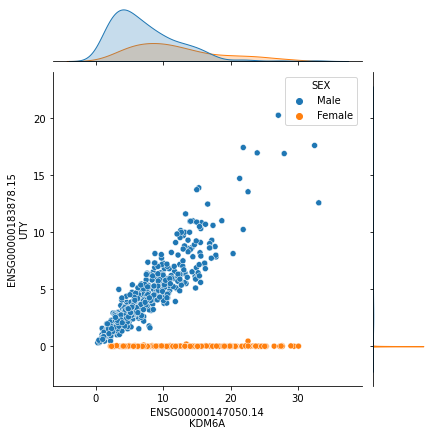

In [35]:
plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Lowest tissues in clustermatch

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-1117F-2426-SM-5EGGH,27.57,0.000000,GTEX-1117F,Female,60-69,4.0
GTEX-113JC-2226-SM-5EGJG,39.33,0.030090,GTEX-113JC,Female,50-59,2.0
GTEX-11DXX-1526-SM-5H115,23.10,0.060890,GTEX-11DXX,Female,60-69,0.0
GTEX-11EM3-1926-SM-5987U,20.52,0.011940,GTEX-11EM3,Female,20-29,0.0
GTEX-11EMC-1826-SM-5A5JT,32.54,0.000000,GTEX-11EMC,Female,60-69,2.0
...,...,...,...,...,...,...
GTEX-ZTPG-2026-SM-5O999,28.68,0.005157,GTEX-ZTPG,Female,20-29,0.0
GTEX-ZV6S-1526-SM-5NQ7O,18.26,0.013180,GTEX-ZV6S,Female,40-49,0.0
GTEX-ZVT2-0426-SM-5E44S,26.37,0.010670,GTEX-ZVT2,Female,50-59,0.0
GTEX-ZXES-0726-SM-5E451,27.06,0.019010,GTEX-ZXES,Female,30-39,0.0


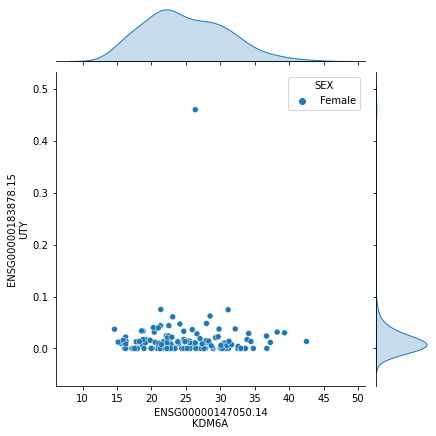

In [36]:
plot_gene_pair(
    "uterus",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

In [37]:
# plot_gene_pair(
#     "fallopian_tube",
#     gene0_id,
#     gene1_id,
#     hue="SEX",
#     kind="scatter",
# )

In [38]:
# plot_gene_pair(
#     "kidney_medulla",
#     gene0_id,
#     gene1_id,
#     hue="SEX",
#     kind="scatter",
# )

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-11DXX-1426-SM-5GIDU,22.21,0.022840,GTEX-11DXX,Female,60-69,0.0
GTEX-11EM3-1726-SM-5N9D1,34.38,0.000000,GTEX-11EM3,Female,20-29,0.0
GTEX-11EMC-1726-SM-5H11P,31.24,0.043400,GTEX-11EMC,Female,60-69,2.0
GTEX-11GSP-0226-SM-5A5KV,26.23,0.014480,GTEX-11GSP,Female,60-69,2.0
GTEX-11I78-1926-SM-59878,17.91,0.022240,GTEX-11I78,Female,50-59,0.0
...,...,...,...,...,...,...
GTEX-ZVT2-0326-SM-5E44G,25.05,0.004439,GTEX-ZVT2,Female,50-59,0.0
GTEX-ZVT3-2626-SM-5GU5L,30.07,0.030870,GTEX-ZVT3,Female,60-69,2.0
GTEX-ZYFG-1726-SM-5GZZB,21.90,0.021910,GTEX-ZYFG,Female,60-69,0.0
GTEX-ZYY3-2726-SM-5EGH4,25.51,0.023940,GTEX-ZYY3,Female,60-69,4.0


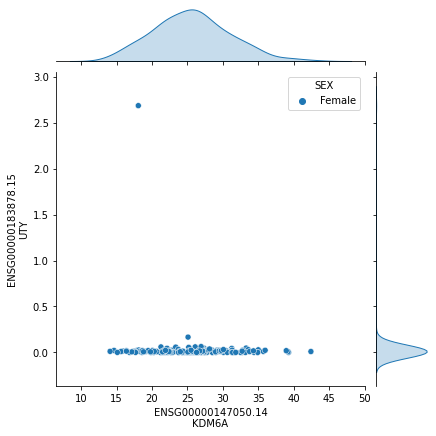

In [39]:
plot_gene_pair(
    "ovary",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-1117F-2526-SM-5GZY6,28.16,0.015530,GTEX-1117F,Female,60-69,4.0
GTEX-113JC-1926-SM-5N9GE,22.28,0.013330,GTEX-113JC,Female,50-59,2.0
GTEX-11DXX-1726-SM-5H11T,16.87,0.004817,GTEX-11DXX,Female,60-69,0.0
GTEX-11EM3-1826-SM-5A5KO,25.00,0.022500,GTEX-11EM3,Female,20-29,0.0
GTEX-11EMC-1926-SM-5A5JU,18.13,0.022270,GTEX-11EMC,Female,60-69,2.0
...,...,...,...,...,...,...
GTEX-ZVT3-2726-SM-5GU5X,25.97,0.000000,GTEX-ZVT3,Female,60-69,2.0
GTEX-ZXES-0626-SM-5E45P,35.18,0.004308,GTEX-ZXES,Female,30-39,0.0
GTEX-ZYVF-0326-SM-5GIES,18.48,0.015490,GTEX-ZYVF,Female,50-59,0.0
GTEX-ZYY3-2626-SM-5N9DH,23.78,0.012820,GTEX-ZYY3,Female,60-69,4.0


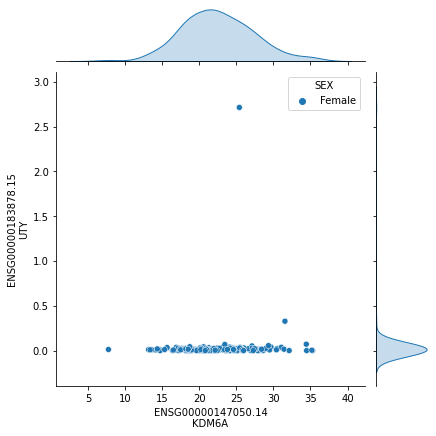

In [40]:
plot_gene_pair(
    "vagina",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

In [41]:
# plot_gene_pair(
#     "cervix_endocervix",
#     gene0_id,
#     gene1_id,
#     hue="SEX",
#     kind="scatter",
# )

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-111FC-3326-SM-5GZYV,9.268,6.988000,GTEX-111FC,Male,60-69,1.0
GTEX-1128S-2826-SM-5N9DI,12.930,0.000000,GTEX-1128S,Female,60-69,2.0
GTEX-117XS-3126-SM-5GIDP,10.840,7.389000,GTEX-117XS,Male,60-69,2.0
GTEX-1192X-3226-SM-5987D,10.780,5.132000,GTEX-1192X,Male,50-59,4.0
GTEX-11DXW-1026-SM-5H11K,10.060,7.823000,GTEX-11DXW,Male,40-49,2.0
...,...,...,...,...,...,...
GTEX-ZUA1-2926-SM-59HL3,12.550,8.619000,GTEX-ZUA1,Male,40-49,2.0
GTEX-ZVT3-2926-SM-5GU6M,11.060,0.021220,GTEX-ZVT3,Female,60-69,2.0
GTEX-ZYFD-2926-SM-5GID9,10.630,4.950000,GTEX-ZYFD,Male,50-59,3.0
GTEX-ZYY3-3026-SM-5GIEJ,12.860,0.004916,GTEX-ZYY3,Female,60-69,4.0


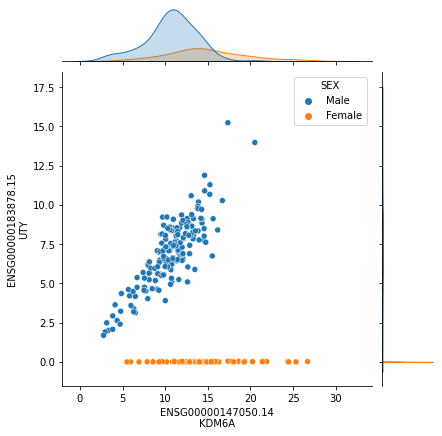

In [42]:
plot_gene_pair(
    "brain_cerebellum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-111CU-1326-SM-5NQ8L,7.586,4.03700,GTEX-111CU,Male,50-59,0.0
GTEX-111YS-1426-SM-5GID8,13.500,3.37000,GTEX-111YS,Male,60-69,0.0
GTEX-1122O-1326-SM-5H11F,21.680,0.03090,GTEX-1122O,Female,60-69,0.0
GTEX-117YX-0326-SM-5GICL,8.964,5.23500,GTEX-117YX,Male,50-59,0.0
GTEX-1192X-2526-SM-59868,10.010,6.39900,GTEX-1192X,Male,50-59,4.0
...,...,...,...,...,...,...
GTEX-ZVT2-2126-SM-5NQ93,21.560,0.02238,GTEX-ZVT2,Female,50-59,0.0
GTEX-ZVZP-1826-SM-5GZXB,10.860,5.04100,GTEX-ZVZP,Male,50-59,0.0
GTEX-ZXES-1526-SM-5NQ95,23.980,0.01305,GTEX-ZXES,Female,30-39,0.0
GTEX-ZYFG-2026-SM-5E43Y,13.780,0.01278,GTEX-ZYFG,Female,60-69,0.0


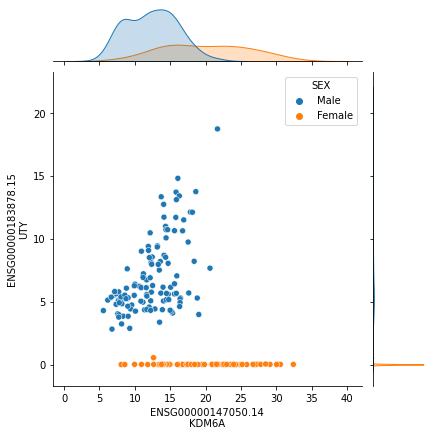

In [43]:
plot_gene_pair(
    "small_intestine_terminal_ileum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-1192X-0011-R9b-SM-DO934,4.806,2.38800,GTEX-1192X,Male,50-59,4.0
GTEX-11DZ1-0011-R9a-SM-DO933,5.319,2.15400,GTEX-11DZ1,Male,50-59,4.0
GTEX-11EMC-0011-R9b-SM-DO921,6.041,0.00000,GTEX-11EMC,Female,60-69,2.0
GTEX-11GSP-0011-R9b-SM-5NQ77,4.092,0.00000,GTEX-11GSP,Female,60-69,2.0
GTEX-11ONC-0011-R9b-SM-5NQ8J,2.787,2.82000,GTEX-11ONC,Male,60-69,2.0
...,...,...,...,...,...,...
GTEX-YJ89-0011-R9a-SM-4SOK7,6.539,5.13400,GTEX-YJ89,Male,60-69,2.0
GTEX-ZAB4-0011-R9a-SM-4SOKG,7.923,7.90800,GTEX-ZAB4,Male,40-49,4.0
GTEX-ZE9C-0011-R9a-SM-4WWCY,5.954,4.79900,GTEX-ZE9C,Male,60-69,2.0
GTEX-ZF28-0011-R9a-SM-4WWDY,7.678,3.00500,GTEX-ZF28,Male,60-69,4.0


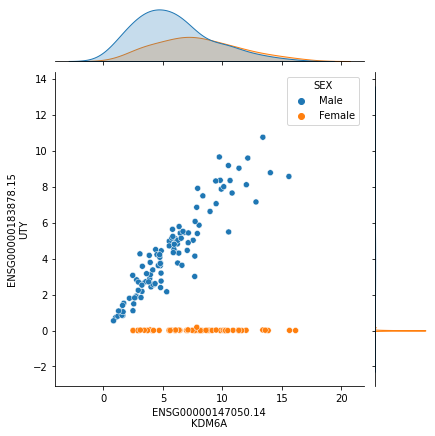

In [44]:
plot_gene_pair(
    "brain_spinal_cord_cervical_c1",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-111CU-1726-SM-5EGHM,17.37,4.825,GTEX-111CU,Male,50-59,0.0
GTEX-111FC-1926-SM-5GZYC,25.74,5.117,GTEX-111FC,Male,60-69,1.0
GTEX-111VG-1926-SM-5GIDO,10.92,2.109,GTEX-111VG,Male,60-69,3.0
GTEX-111YS-2026-SM-5EGGL,22.77,4.500,GTEX-111YS,Male,60-69,0.0
GTEX-117XS-2026-SM-5GID1,16.81,4.382,GTEX-117XS,Male,60-69,2.0
...,...,...,...,...,...,...
GTEX-ZVTK-0126-SM-57WDG,20.14,4.964,GTEX-ZVTK,Male,20-29,1.0
GTEX-ZVZP-2226-SM-57WBF,16.57,4.340,GTEX-ZVZP,Male,50-59,0.0
GTEX-ZYFC-0126-SM-5GIEH,24.19,5.838,GTEX-ZYFC,Male,50-59,2.0
GTEX-ZYT6-2726-SM-5GICP,19.32,4.689,GTEX-ZYT6,Male,30-39,1.0


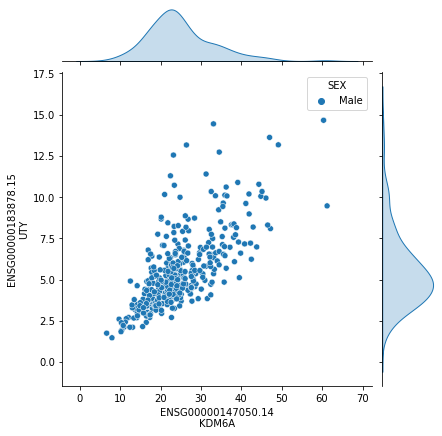

In [45]:
plot_gene_pair(
    "testis",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Highest tissues in clustermatch

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-111VG-0008-SM-5Q5BG,7.302,4.53900,GTEX-111VG,Male,60-69,3.0
GTEX-111YS-0008-SM-5Q5BH,6.931,4.95800,GTEX-111YS,Male,60-69,0.0
GTEX-1122O-0008-SM-5QGR2,11.250,0.01423,GTEX-1122O,Female,60-69,0.0
GTEX-1128S-0008-SM-5Q5DP,11.030,0.00000,GTEX-1128S,Female,60-69,2.0
GTEX-113IC-0008-SM-5QGRF,6.245,4.80200,GTEX-113IC,Male,60-69,NaN
...,...,...,...,...,...,...
GTEX-ZVTK-0008-SM-57WDA,7.314,5.17900,GTEX-ZVTK,Male,20-29,1.0
GTEX-ZVZP-0008-SM-51MSX,6.643,4.82800,GTEX-ZVZP,Male,50-59,0.0
GTEX-ZVZQ-0008-SM-51MSK,9.477,0.00000,GTEX-ZVZQ,Female,60-69,1.0
GTEX-ZXES-0008-SM-57WCX,11.110,0.00000,GTEX-ZXES,Female,30-39,0.0


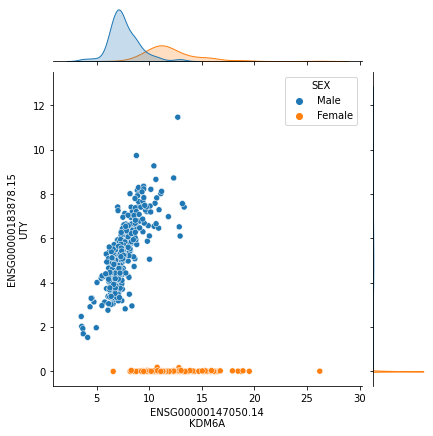

In [46]:
plot_gene_pair(
    "cells_cultured_fibroblasts",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-1117F-2826-SM-5GZXL,15.790,0.005073,GTEX-1117F,Female,60-69,4.0
GTEX-111YS-1926-SM-5GICC,16.150,9.162000,GTEX-111YS,Male,60-69,0.0
GTEX-1122O-1226-SM-5H113,17.950,0.025600,GTEX-1122O,Female,60-69,0.0
GTEX-117XS-1926-SM-5GICO,10.660,7.692000,GTEX-117XS,Male,60-69,2.0
GTEX-117YX-1426-SM-5H12H,8.202,5.114000,GTEX-117YX,Male,50-59,0.0
...,...,...,...,...,...,...
GTEX-ZYFC-0826-SM-5E44K,9.057,8.395000,GTEX-ZYFC,Male,50-59,2.0
GTEX-ZYT6-0126-SM-5E45J,7.998,6.843000,GTEX-ZYT6,Male,30-39,1.0
GTEX-ZYW4-0826-SM-5GIDG,7.993,6.478000,GTEX-ZYW4,Male,60-69,3.0
GTEX-ZZ64-1226-SM-5E43R,6.069,4.833000,GTEX-ZZ64,Male,20-29,0.0


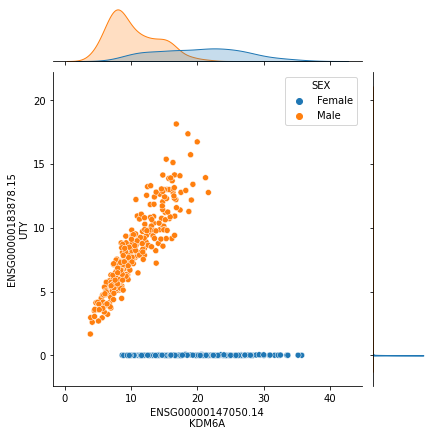

In [47]:
plot_gene_pair(
    "breast_mammary_tissue",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Pearson low, Clustermatch high

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-11DXW-0011-R3b-SM-DNZZE,2.046,1.548000,GTEX-11DXW,Male,40-49,2.0
GTEX-11DZ1-0011-R3a-SM-DNZYY,2.744,1.211000,GTEX-11DZ1,Male,50-59,4.0
GTEX-11GSO-0011-R3b-SM-57WB2,2.628,1.850000,GTEX-11GSO,Male,60-69,2.0
GTEX-11GSP-0011-R3a-SM-9QEGF,1.932,0.000000,GTEX-11GSP,Female,60-69,2.0
GTEX-11UD1-0011-R3a-SM-5BC6S,3.668,0.003380,GTEX-11UD1,Female,40-49,3.0
...,...,...,...,...,...,...
GTEX-ZE9C-0011-R3a-SM-4WKGT,2.419,1.538000,GTEX-ZE9C,Male,60-69,2.0
GTEX-ZF28-0011-R3a-SM-4WWDA,2.373,1.538000,GTEX-ZF28,Male,60-69,4.0
GTEX-ZUA1-0011-R3a-SM-4YCEE,2.923,2.851000,GTEX-ZUA1,Male,40-49,2.0
GTEX-ZVT3-0011-R3b-SM-51MTJ,1.927,0.004899,GTEX-ZVT3,Female,60-69,2.0


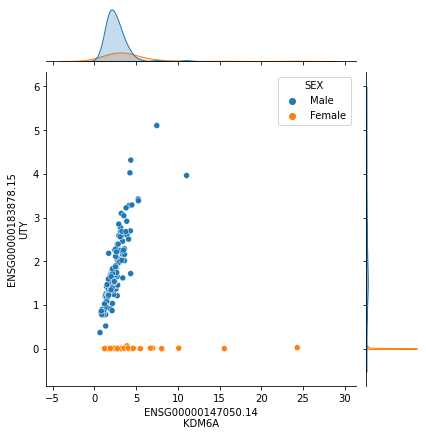

In [48]:
plot_gene_pair(
    "brain_anterior_cingulate_cortex_ba24",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-11NUK-0011-R4a-SM-DO12B,2.0240,1.65000,GTEX-11NUK,Male,50-59,2.0
GTEX-11ONC-0011-R4b-SM-DO93H,2.7150,2.04900,GTEX-11ONC,Male,60-69,2.0
GTEX-11PRG-0011-R4a-SM-DNZZR,2.3430,1.84400,GTEX-11PRG,Male,50-59,2.0
GTEX-11TTK-0011-R4a-SM-DNZZU,3.3170,0.00000,GTEX-11TTK,Female,60-69,4.0
GTEX-11ZU8-0011-R4a-SM-5BC6Y,0.7348,0.66160,GTEX-11ZU8,Male,60-69,4.0
...,...,...,...,...,...,...
GTEX-YFC4-0011-R4a-SM-4RGLQ,4.6220,0.00609,GTEX-YFC4,Female,40-49,1.0
GTEX-ZAB4-0011-R4a-SM-4SOKB,3.9250,2.65700,GTEX-ZAB4,Male,40-49,4.0
GTEX-ZAK1-0011-R4a-SM-6AJBK,4.0880,0.00000,GTEX-ZAK1,Female,50-59,2.0
GTEX-ZE9C-0011-R4a-SM-4WKH6,0.9569,0.66090,GTEX-ZE9C,Male,60-69,2.0


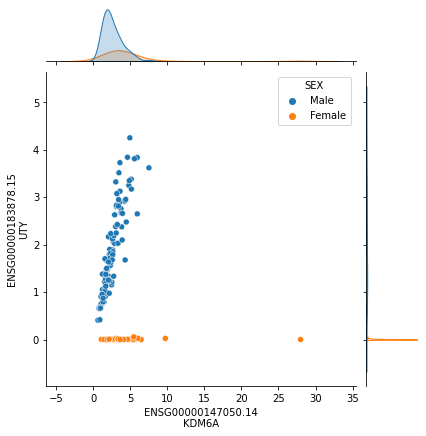

In [49]:
plot_gene_pair(
    "brain_amygdala",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-1192X-0011-R10a-SM-DO941,3.508,2.175000,GTEX-1192X,Male,50-59,4.0
GTEX-11DXY-0011-R10b-SM-DO12C,2.748,2.044000,GTEX-11DXY,Male,60-69,2.0
GTEX-11DYG-0011-R10b-SM-DNZZO,3.136,1.705000,GTEX-11DYG,Male,60-69,2.0
GTEX-11DZ1-0011-R10b-SM-DO943,3.573,1.843000,GTEX-11DZ1,Male,50-59,4.0
GTEX-11EI6-0011-R10a-SM-DO93R,2.953,1.716000,GTEX-11EI6,Male,60-69,4.0
...,...,...,...,...,...,...
GTEX-ZUA1-0011-R10a-SM-51MT6,2.484,1.927000,GTEX-ZUA1,Male,40-49,2.0
GTEX-ZV68-0011-R10a-SM-51MT7,2.119,0.000000,GTEX-ZV68,Female,50-59,2.0
GTEX-ZVT3-0011-R10b-SM-57WB6,3.074,0.009043,GTEX-ZVT3,Female,60-69,2.0
GTEX-ZVZQ-0011-R10b-SM-51MRT,3.981,0.009682,GTEX-ZVZQ,Female,60-69,1.0


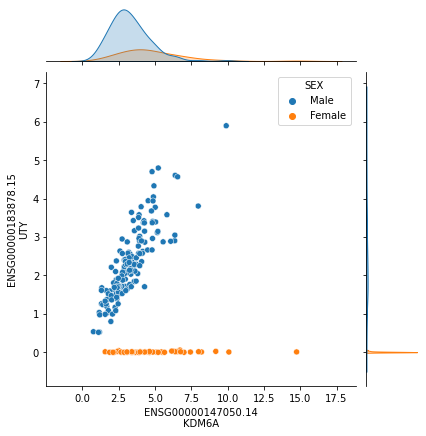

In [50]:
plot_gene_pair(
    "brain_frontal_cortex_ba9",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-OIZF-1926-SM-7PBZS,10.190,5.51900,GTEX-OIZF,Male,60-69,0.0
GTEX-P44H-2226-SM-E9U4P,10.020,8.31600,GTEX-P44H,Male,40-49,4.0
GTEX-QEL4-1826-SM-EZ6KU,9.265,5.04700,GTEX-QEL4,Male,50-59,3.0
GTEX-RN64-2426-SM-EZ6L2,6.642,5.05700,GTEX-RN64,Male,50-59,1.0
GTEX-RU72-2526-SM-EWRML,5.445,0.00000,GTEX-RU72,Female,50-59,2.0
GTEX-S32W-1126-SM-4AD5V,15.850,0.02429,GTEX-S32W,Female,50-59,0.0
GTEX-S33H-1926-SM-EYYVH,8.401,6.41700,GTEX-S33H,Male,30-39,2.0
GTEX-S3XE-1226-SM-4AD4L,16.010,9.67600,GTEX-S3XE,Male,50-59,0.0
GTEX-S4Q7-0926-SM-4AD5D,14.680,10.93000,GTEX-S4Q7,Male,20-29,0.0
GTEX-S4UY-0926-SM-4AD6O,23.370,0.01596,GTEX-S4UY,Female,40-49,0.0


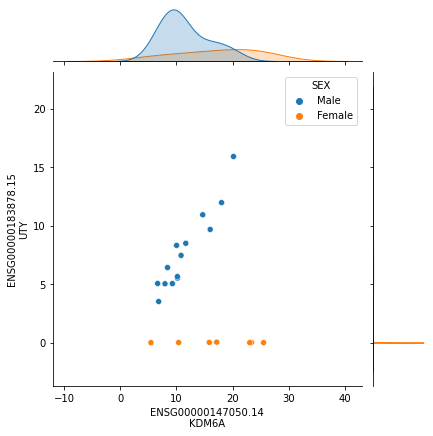

In [51]:
plot_gene_pair(
    "bladder",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-1117F-0726-SM-5GIEN,6.324,0.004228,GTEX-1117F,Female,60-69,4.0
GTEX-111FC-0626-SM-5N9CU,4.512,4.248000,GTEX-111FC,Male,60-69,1.0
GTEX-111VG-0326-SM-5GZX7,2.813,2.267000,GTEX-111VG,Male,60-69,3.0
GTEX-111YS-0326-SM-5GZZ3,4.154,3.159000,GTEX-111YS,Male,60-69,0.0
GTEX-1122O-0626-SM-5N9B9,6.680,0.003369,GTEX-1122O,Female,60-69,0.0
...,...,...,...,...,...,...
GTEX-ZYFG-0526-SM-5GZXX,4.830,0.045870,GTEX-ZYFG,Female,60-69,0.0
GTEX-ZYT6-0926-SM-5GIEM,4.137,2.648000,GTEX-ZYT6,Male,30-39,1.0
GTEX-ZYVF-1826-SM-5E44F,2.958,0.028680,GTEX-ZYVF,Female,50-59,0.0
GTEX-ZZPT-0926-SM-5GICZ,3.145,1.951000,GTEX-ZZPT,Male,50-59,4.0


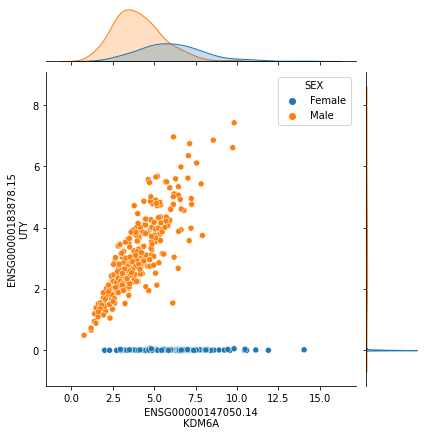

In [52]:
plot_gene_pair(
    "heart_atrial_appendage",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Spearman low, Clustermatch high

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-111FC-0826-SM-5GZWO,3.3640,1.990000,GTEX-111FC,Male,60-69,1.0
GTEX-111YS-0426-SM-5987O,2.9800,1.700000,GTEX-111YS,Male,60-69,0.0
GTEX-1122O-0826-SM-5GICV,4.8580,0.010510,GTEX-1122O,Female,60-69,0.0
GTEX-117YW-0326-SM-5N9CY,1.7840,1.053000,GTEX-117YW,Male,50-59,3.0
GTEX-117YX-1126-SM-5H128,3.5150,2.046000,GTEX-117YX,Male,50-59,0.0
...,...,...,...,...,...,...
GTEX-ZYFC-1126-SM-5E44W,1.4990,0.986100,GTEX-ZYFC,Male,50-59,2.0
GTEX-ZYFG-0426-SM-5E43M,5.0860,0.008376,GTEX-ZYFG,Female,60-69,0.0
GTEX-ZYT6-1726-SM-5E44P,0.6531,0.373000,GTEX-ZYT6,Male,30-39,1.0
GTEX-ZYW4-0926-SM-59HJS,1.9190,1.707000,GTEX-ZYW4,Male,60-69,3.0


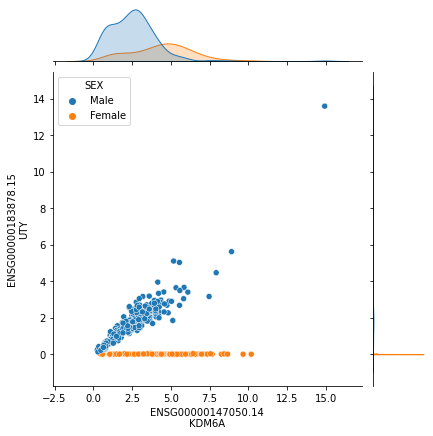

In [53]:
plot_gene_pair(
    "heart_left_ventricle",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-1117F-1326-SM-5EGHH,14.110,0.01681,GTEX-1117F,Female,60-69,4.0
GTEX-111CU-1026-SM-5EGIL,4.856,2.89900,GTEX-111CU,Male,50-59,0.0
GTEX-111YS-1326-SM-5EGGK,6.112,4.56700,GTEX-111YS,Male,60-69,0.0
GTEX-1122O-0926-SM-9YFLC,6.156,0.01357,GTEX-1122O,Female,60-69,0.0
GTEX-1128S-0926-SM-5GZZU,14.300,0.02838,GTEX-1128S,Female,60-69,2.0
...,...,...,...,...,...,...
GTEX-ZYT6-2126-SM-5GZZ4,7.478,6.68600,GTEX-ZYT6,Male,30-39,1.0
GTEX-ZYVF-1026-SM-5E44V,11.410,0.02110,GTEX-ZYVF,Female,50-59,0.0
GTEX-ZYW4-2226-SM-5GZYG,11.910,10.17000,GTEX-ZYW4,Male,60-69,3.0
GTEX-ZZ64-0626-SM-5GZWR,7.398,3.87200,GTEX-ZZ64,Male,20-29,0.0


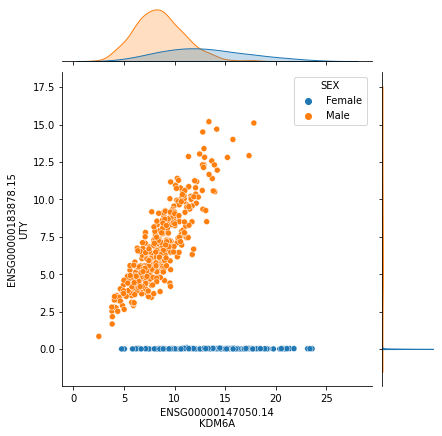

In [54]:
plot_gene_pair(
    "adipose_visceral_omentum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-1117F-2926-SM-5GZYI,22.870,0.02361,GTEX-1117F,Female,60-69,4.0
GTEX-111CU-1126-SM-5EGIM,12.240,5.90500,GTEX-111CU,Male,50-59,0.0
GTEX-111FC-2526-SM-5GZXU,10.320,8.38400,GTEX-111FC,Male,60-69,1.0
GTEX-111VG-1626-SM-5EGIO,13.300,6.41500,GTEX-111VG,Male,60-69,3.0
GTEX-111YS-1526-SM-5GZYW,16.560,8.25300,GTEX-111YS,Male,60-69,0.0
...,...,...,...,...,...,...
GTEX-ZYVF-0926-SM-5E44J,22.440,0.02711,GTEX-ZYVF,Female,50-59,0.0
GTEX-ZYW4-0626-SM-59HJR,9.345,7.40900,GTEX-ZYW4,Male,60-69,3.0
GTEX-ZYY3-2926-SM-5GIEB,33.740,0.00000,GTEX-ZYY3,Female,60-69,4.0
GTEX-ZZ64-1026-SM-5GZXG,16.710,7.70000,GTEX-ZZ64,Male,20-29,0.0


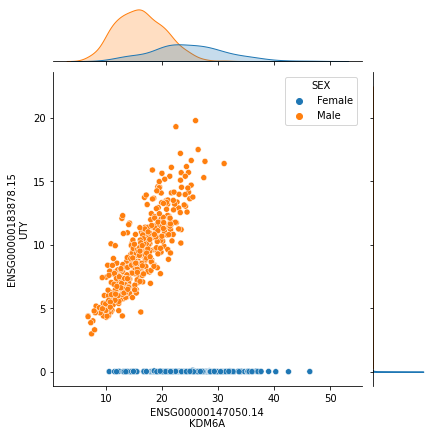

In [55]:
plot_gene_pair(
    "skin_not_sun_exposed_suprapubic",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

,ENSG00000147050.14,ENSG00000183878.15,SUBJID,SEX,AGE,DTHHRDY
GTEX-111CU-0526-SM-5EGHK,3.846,2.275000,GTEX-111CU,Male,50-59,0.0
GTEX-111YS-1226-SM-5EGGJ,3.285,2.133000,GTEX-111YS,Male,60-69,0.0
GTEX-1122O-0726-SM-5GIEV,6.272,0.009831,GTEX-1122O,Female,60-69,0.0
GTEX-1128S-0826-SM-5GZZI,6.574,0.024010,GTEX-1128S,Female,60-69,2.0
GTEX-117YX-0226-SM-5EGH6,3.922,2.905000,GTEX-117YX,Male,50-59,0.0
...,...,...,...,...,...,...
GTEX-ZYFG-0826-SM-5BC5T,8.450,0.026490,GTEX-ZYFG,Female,60-69,0.0
GTEX-ZYT6-1326-SM-5E453,2.554,2.182000,GTEX-ZYT6,Male,30-39,1.0
GTEX-ZYW4-2126-SM-59HJ9,4.890,4.542000,GTEX-ZYW4,Male,60-69,3.0
GTEX-ZYY3-0826-SM-5E44R,5.077,0.007030,GTEX-ZYY3,Female,60-69,4.0


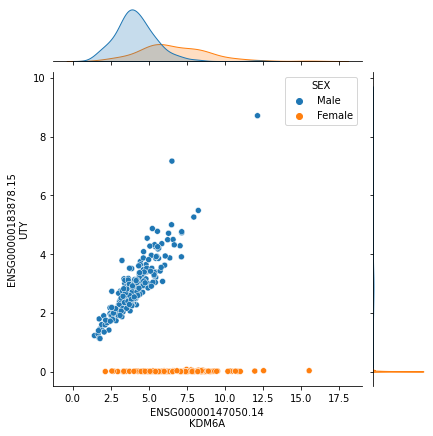

In [56]:
plot_gene_pair(
    "pancreas",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)